In [158]:
from pathlib import Path
import compiler_gym

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
device = 'cuda'

In [159]:
root_path = os.environ.get("COMPILER2_ROOT")
env = compiler_gym.make("llvm-v0")
print(f'Number of actions = {len(env.action_space.flags)}')
csv_path = Path(root_path + "/results/random-compiler2-v0/2022-04-14/13-19-22/3177910/results.csv")
print(csv_path)
print(f"Is file good = {csv_path.is_file()}")

Number of actions = 124
/home/dx4/tools/compiler2/results/random-compiler2-v0/2022-04-14/13-19-22/3177910/results.csv
Is file good = True


./compiler_gym-llvm-service: /lib64/libtinfo.so.5: no version information available (required by ./compiler_gym-llvm-service)


In [160]:
columns = ["BenchmarkName", "State", "NextState", "Action", "CommandLine", "Reward"]
df = pd.read_csv(csv_path, names=columns, header=1)

df['State'] = df['State'].apply(lambda x:np.fromstring(x,sep=' '))
state_min = np.min(np.stack(df['State']),0)
state_max = np.max(np.stack(df['State']),0)
df['State'] = df['State'].apply(lambda x: (x-state_min)/(state_max-state_min+1e-9))
df['State'] = df['State'].apply(lambda x:torch.tensor(x).float())

df['NextState'] = df['NextState'].apply(lambda x:np.fromstring(x,sep=' '))
state_min = np.min(np.stack(df['NextState']),0)
state_max = np.max(np.stack(df['NextState']),0)
df['NextState'] = df['NextState'].apply(lambda x: (x-state_min)/(state_max-state_min+1e-9))
df['NextState'] = df['NextState'].apply(lambda x:torch.tensor(x).float())


action_kinds = pd.Categorical(df['Action'], categories=env.action_space.flags)
action_one_hot = pd.get_dummies(action_kinds)

df = df.dropna()
df['Action'] = action_one_hot.values.tolist()
df['Action'] = df['Action'].apply(lambda x: torch.tensor(x).float())
df['Reward'] = df['Reward'].apply(lambda x: torch.tensor(x).float())

df.head()

,BenchmarkName,State,NextState,Action,CommandLine,Reward
0,benchmark://poj104-v0/28_982,"[tensor(0.0016), tensor(0.0109), tensor(0.0043...","[tensor(0.0016), tensor(0.0109), tensor(0.0043...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....",opt -mergefunc -dse -loop-load-elim -loop-vers...,tensor(0.)
1,benchmark://poj104-v0/28_982,"[tensor(0.0016), tensor(0.0109), tensor(0.0043...","[tensor(0.0016), tensor(0.0109), tensor(0.0043...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....",opt -mergefunc -dse -loop-load-elim -loop-vers...,tensor(0.)
2,benchmark://poj104-v0/28_982,"[tensor(0.0016), tensor(0.0109), tensor(0.0043...","[tensor(0.0022), tensor(0.0025), tensor(0.0020...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....",opt -instcombine -break-crit-edges -flattencfg...,tensor(0.)
3,benchmark://poj104-v0/28_982,"[tensor(0.0022), tensor(0.0025), tensor(0.0020...","[tensor(0.0022), tensor(0.0025), tensor(0.0020...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....",opt -instcombine -break-crit-edges -flattencfg...,tensor(0.)
4,benchmark://poj104-v0/28_982,"[tensor(0.0022), tensor(0.0025), tensor(0.0020...","[tensor(0.0021), tensor(0.0071), tensor(0.0023...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....",opt -instcombine -break-crit-edges -flattencfg...,tensor(0.0071)


In [161]:
class experienceDataset(Dataset):
    def __init__(self,experience):
        self.experience = experience
    def __getitem__(self, i):
        # return S,A,R,S'
        return self.experience['State'].iloc[i].to(device),self.experience['Action'].iloc[i].to(device),self.experience['Reward'].iloc[i].to(device),self.experience['NextState'].iloc[i].to(device),
    def __len__(self):
        return self.experience.shape[0]

In [162]:
class Q_net(nn.Module):
    def __init__(self,in_size,out_size,hidden_size,dropout):
        super(Q_net,self).__init__()
        self.l1 = nn.Linear(in_size,hidden_size)
        self.l2 = nn.Linear(hidden_size,hidden_size)
        self.l3 = nn.Linear(hidden_size,hidden_size)
        self.l4 = nn.Linear(hidden_size,hidden_size)
        self.l5 = nn.Linear(hidden_size,hidden_size)
        self.l6 = nn.Linear(hidden_size,hidden_size)
        self.l7 = nn.Linear(hidden_size,out_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self,x):
        x = F.leaky_relu(self.l1(x))
        x = self.dropout(x)
        y = F.leaky_relu(self.l2(x))
        y = self.dropout(y)
        x = (x+y)*0.5
        x = F.leaky_relu(self.l3(x))
        x = self.dropout(x)
        y = F.leaky_relu(self.l4(x))
        y = self.dropout(y)
        x = (x+y)*0.5
        x = F.leaky_relu(self.l5(x))
        x = self.dropout(x)
        y = F.leaky_relu(self.l6(x))
        y = self.dropout(y)
        x = (x+y)*0.5
        return self.l7(x)

In [163]:
test_size = len(df) // 5
train_size = len(df) - test_size
experience = experienceDataset(df)
train_set, test_set = torch.utils.data.random_split(experience, [train_size, test_size])
batch_size = 1000
trainLoad = DataLoader(train_set,batch_size=batch_size,shuffle=True)
testLoad = DataLoader(test_set,batch_size=batch_size,shuffle=True)
policy_net = Q_net(28,124,512,0.5).to(device)
target_net = Q_net(28,124,512,0.5).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(policy_net.parameters())
train_losses = []
test_losses = []
num_epochs = 301
test_every = 5
gamma = 0.9

In [168]:
for epoch in tqdm(range(num_epochs)):
    # loop_inner = tqdm(total=train_size//batch_size,position=0,leave=False)
    policy_net.train()
    for S,A,R,S_ in trainLoad:
        r = torch.sum(torch.mul(policy_net(S),A),1)
        r_hat = R + torch.max(target_net(S_),1).values*gamma
        
        loss = criterion(r,r_hat)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
    #     loop_inner.set_description('epoch:{}, loss:{:.4f}'.format(epoch, loss.item()))
    #     loop_inner.update(1)
    # loop_inner.close()
    if epoch % test_every == 0:
        with torch.no_grad():
            policy_net.eval()
            for S,A,R,S_ in trainLoad:
                r = torch.sum(torch.mul(policy_net(S),A),1)
                r_hat = R + torch.max(target_net(S_),1).values*gamma

                loss = criterion(r,r_hat)
                test_losses.append(loss.item())
    target_net.load_state_dict(policy_net.state_dict())

100%|██████████| 301/301 [00:03<00:00, 79.59it/s]


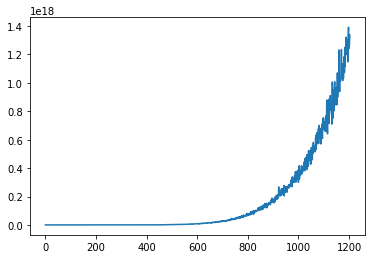

In [169]:
plt.figure(facecolor='white')
plt.plot(train_losses)

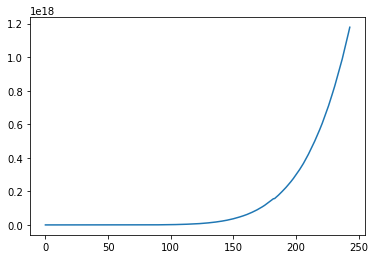

In [170]:
plt.figure(facecolor='white')
plt.plot(test_losses)

In [171]:
def get_action(state,network,epsilon):
    p = random.random()
    if p > epsilon:
        with torch.no_grad():
            return torch.max(network(state),1).indices[0].item()
    else:
        return random.randint(0,124)

In [172]:
get_action(df['State'].iloc[0],target_net,1)

110

In [173]:
get_action(df['State'].iloc[0].unsqueeze(0).to(device),target_net,0)

84

In [174]:
model_scripted = torch.jit.script(target_net) # Export to TorchScript
model_scripted.save('deep_q.pt') # Save